In [1]:
%matplotlib inline
import pandas as pd
import os
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from unidecode import unidecode
from wordcloud import WordCloud
from gensim import utils
import gensim.parsing.preprocessing as gsp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
from autocorrect import Speller

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', 130)
warnings.filterwarnings('ignore')

In [3]:
path = "./data/"
files = [f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f)) and f.endswith(".gzip")]

In [4]:
start_time = time.time()
data = pd.DataFrame()
for file in files:
    data = pd.concat([data, pd.read_csv(os.path.join(path, file), compression="gzip")])
print("Took ", time.time() - start_time, "s to run.")

Took  52.4372923374176 s to run.


In [5]:
data = data.reset_index(drop=True)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4638238 entries, 0 to 4638237
Data columns (total 18 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Unnamed: 0      int64 
 1   userid          int64 
 2   username        object
 3   acctdesc        object
 4   location        object
 5   following       int64 
 6   followers       int64 
 7   totaltweets     int64 
 8   usercreatedts   object
 9   tweetid         int64 
 10  tweetcreatedts  object
 11  retweetcount    int64 
 12  text            object
 13  hashtags        object
 14  language        object
 15  coordinates     object
 16  favorite_count  int64 
 17  extractedts     object
dtypes: int64(8), object(10)
memory usage: 637.0+ MB


In [6]:
data = data.drop(columns=['Unnamed: 0'])

In [47]:
data.head()

userid         username  \
0  1466752038960656385   Curtin2Tiffany   
1  1111276809302216710           5ela60   
2  1364735420236505088     StatistWomen   
3            597779527  OurTurnToRescue   
4           1646145848   DrWAVeSportCd1   

                                                                                                                            acctdesc  \
0                                                                   I am just like everyone else.  The universe experiencing itself.   
1                                                                                             الأب ..الأخ ..الجار ..الحبيب .. السديك   
2                                                                                                                                 🇹🇷   
3     Issues: Threats to Democracy, Racism, GOP corruption, Climate Change, and Health Care\nCellist, Zen Buddhist, Lover of animals   
4  Addicted to News, Music, Cooking, Gardens, Outdoors, Tennis, Politics. 🖕🏼T, @GOP, @NRA #Putin‼️ 💙 #Democrats #Resist #LGBTQ FA...   

          location  following  followers  totaltweets  \
0    Colorado, USA        253         40           94   
1              NaN        167          9          656   
2  Cumhur İttifakı       1771       1766        37009   
3              NaN       4847       4080        33666   
4              USA       5002       3950       466629   

                usercreatedts              tweetid       tweetcreatedts  \
0  2021-12-03 12:52:22.000000  1497724980259262467  2022-02-27 00:07:16   
1  2019-03-28 14:40:12.000000  1497724980271984641  2022-02-27 00:07:16   
2  2021-02-25 00:35:28.000000  1497724980322349058  2022-02-27 00:07:16   
3  2012-06-02 21:53:59.000000  1497724980573966346  2022-02-27 00:07:16   
4  2013-08-04 21:07:08.000000  1497724980653694976  2022-02-27 00:07:16   

   retweetcount  \
0             5   
1            28   
2             3   
3             1   
4           277   

                                                                                                                                text  \
0  #UkraineRussiaWar Captured Russian soldiers\n\n"They said what their own battalion, where they are from and then told him it w...   
1  Like everybody else I am rooting for Ukraine to fight off Russia, but seeing this video is truly sad. These soldiers are cluel...   
2  #Ukrayna Güvenlik Servisi, #Rus finosu #Kadirov'un konvoyunun Gostomel yakınlarında imha edildiğini bildirdi.\n\n#SİHA Reis'e ...   
3                         We elected a game show host and got a clown. #Ukraine elected a comedian and got a hero. (Source: Unknown)   
4  Ukrainian soldiers wearing sunflowers in their hair\n\n🌻Sunflowers are the national flower of Ukraine🇺🇦\n\n#Ukraine #Ukrania #...   

                                                                                                                            hashtags  \
0                                                                                [{'text': 'UkraineRussiaWar', 'indices': [19, 36]}]   
1                                                                                                                                 []   
2  [{'text': 'Ukrayna', 'indices': [15, 23]}, {'text': 'Rus', 'indices': [42, 46]}, {'text': 'Kadirov', 'indices': [54, 62]}, {'t...   
3                                                                                         [{'text': 'Ukraine', 'indices': [63, 71]}]   
4                                           [{'text': 'Ukraine', 'indices': [122, 130]}, {'text': 'Ukrania', 'indices': [131, 139]}]   

  language coordinates  favorite_count                 extractedts  
0       en         NaN               0  2022-02-27 00:09:33.084131  
1       en         NaN               0  2022-02-27 00:09:33.068011  
2       tr         NaN               0  2022-02-27 00:09:33.059979  
3       en         NaN               0  2022-02-27 00:09:33.051823  
4       en         NaN               0  2022-02-27 0

## Missing Values

<AxesSubplot:>

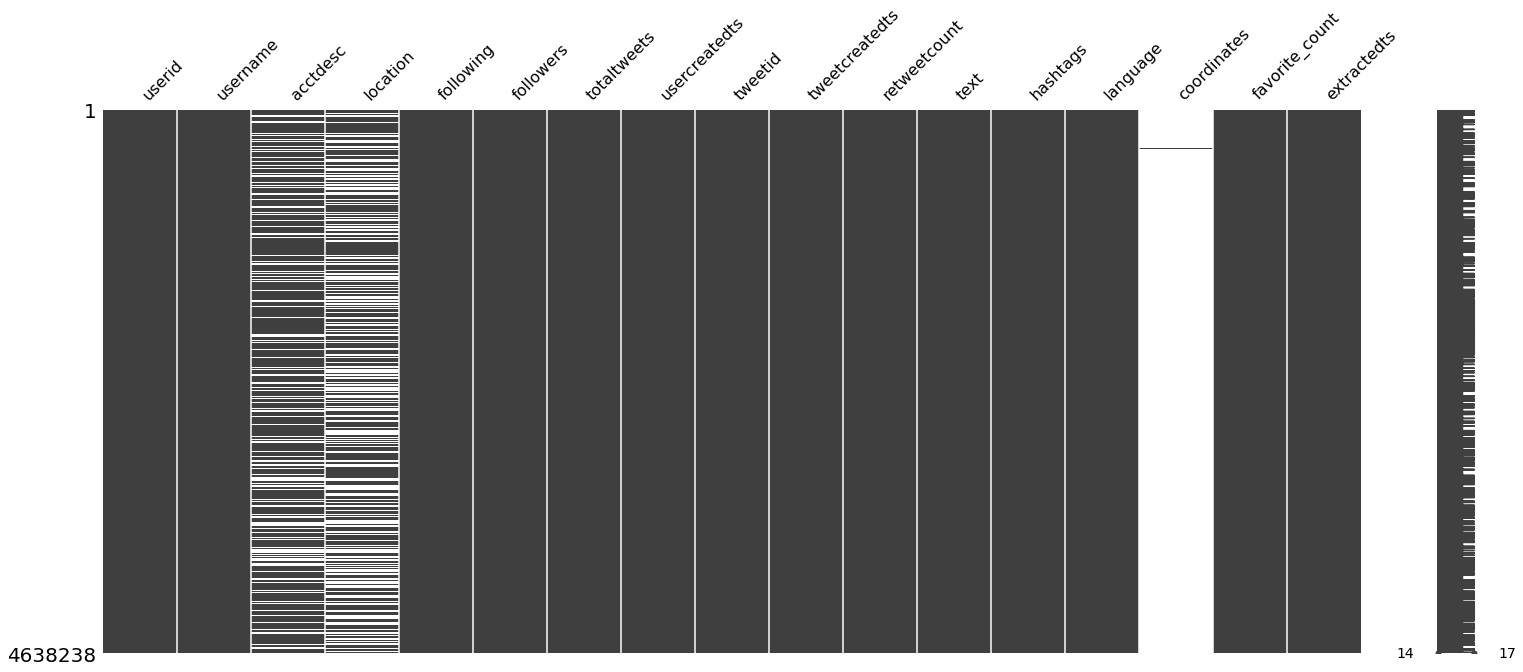

In [48]:
msno.matrix(data)

## Language Distribution

Text(0, 0.5, 'Count')

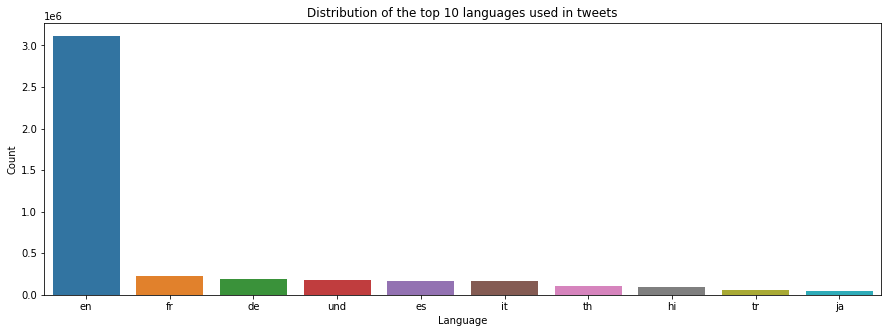

In [70]:
plt.figure(figsize=(15, 5))
sns.countplot(x="language", data=data, order=data.language.value_counts().iloc[:10].index)
plt.title("Distribution of the top 10 languages used in tweets")
plt.xlabel('Language')
plt.ylabel('Count')

## Hashtags

In [7]:
def evaluate_hashtags(x):
    hashtags = []
    
    a = eval(str(x))
    
    for item in a:
        hashtags.append(str(unidecode(item["text"])).lower())
        hashtags = list(set(hashtags))
        
    return hashtags

In [55]:
start_time = time.time()
masterlist = []
hashtagsListCollection = data["hashtags"].apply(evaluate_hashtags)

for hashtagsList in hashtagsListCollection:
    masterlist.extend(hashtagsList)
print("Took", time.time() - start_time, "s to run.")

Took 100.42411041259766 s to run.


In [56]:
del hashtagsListCollection

In [42]:
from PIL import Image

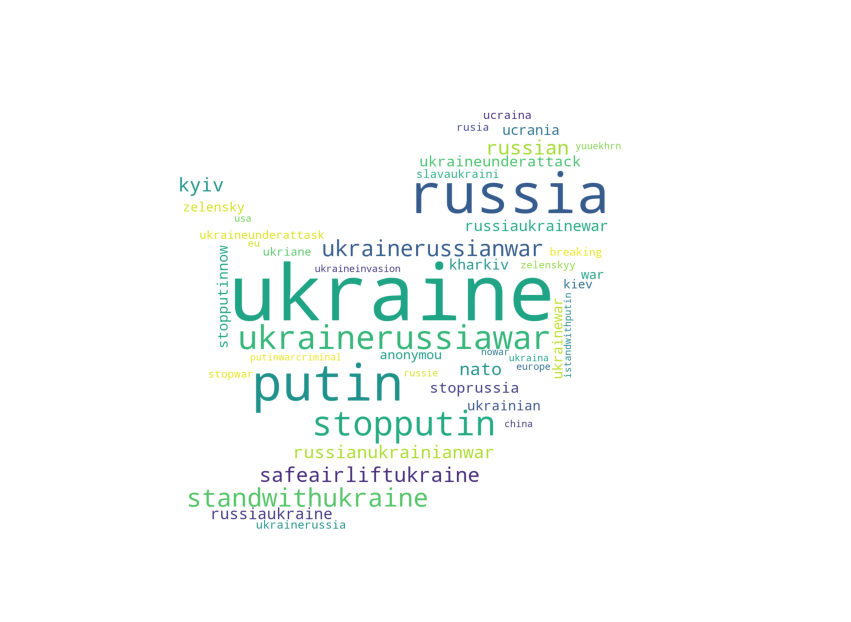

In [140]:
fig, ax = plt.subplots(figsize=(15,15))
mask = np.array(Image.open("twitter.png"))
hashtags_wc = WordCloud(width=1024, height=768,
                collocations=False, max_words=45,
                background_color='white', mask=mask).generate(" ".join(masterlist))
ax.axis("off")
ax.imshow(hashtags_wc)

## Top 5 Retweeted Tweets

In [185]:
data[data.language == "en"].drop_duplicates("text", keep="last").nlargest(5, ["retweetcount", "followers"])

Unnamed: 0               userid         username  \
5865844     4061950  1457316151814651904  IugQhJGUTlHJMel   
5799804     3995910  1124907634597847040       PEIRCE2005   
5867565     4063671             37879463          el_guin   
5867535     4063641            417237173  The_Fit_Gourmet   
5864584     4060690           1052870184      MinhTrietPT   

                                                                                                                              acctdesc  \
5865844                                                                                                                        BATTERA   
5799804                                                  16|R.I.P. Nintendo 3DS and Wii U eshops on March 2023|I tend to retweet a lot   
5867565                                                                                                                            NaN   
5867535                                                Ex-Montrealer in Toronto. Fan of dogs, daffodils and gelato. Opinions my own.🇺🇦   
5864584  APT Hunting, Threat Hunting, Incident Response, Forensics Analysis, Red Team/Internal System Penetration Testing as a Service   

                           location  following  followers  totaltweets  \
5865844                         NaN         49         10          222   
5799804                   Australia        745        387        12324   
5867565                         NaN        367         71          787   
5867535                      Canada        762        158         4589   
5864584  https://fb.com/novasec.vn/       4999       2302         2426   

                      usercreatedts              tweetid      tweetcreatedts  \
5865844  2021-11-07 11:57:14.000000  1501345727171031043 2022-03-08 23:54:49   
5799804  2019-05-05 05:24:14.000000  1501299193675014144 2022-03-08 20:49:55   
5867565  2009-05-05 07:28:56.000000  1501346884966707202 2022-03-08 23:59:25   
5867535  2011-11-20 18:07:35.000000  1501346865425620995 2022-03-08 23:59:21   
5864584  2013-01-01 15:58:03.000000  1501344982560489476 2022-03-08 23:51:52   

         retweetcount  \
5865844        147636   
5799804        107699   
5867565        101986   
5867535         69103   
5864584         60935   

                                                                                                                                                                                                                                                                                                text  \
5865844  .@ZelenskyyUa's tv address to the Russian (!) people might be the most moving speech that I've ever seen in my entire life. The whole world needs to see, understand and share this crucial Ukrainian message.\n#StandWithUkraine #Ukraine #Україна #Russia #Россия https://t.co/WoMOgqXTWX   
5799804                                                                                                       My daughter and I surviving the night in Ukraine. We are real people at war with crazy dictator and we need the world’s support right now\n\n#StandWithUkraine https://t.co/FvdmY4GACj   
5867565                                                                                                                                     This, out of #Ukraine, is 100% one of the most incredible videos I have ever seen.\n\nThis Russian POW has the heart of a lion 🦁 https://t.co/KIx1rsN0CZ   
5867535                                                                                                                                                                      Little girl singing "Let it go" in a shelter\n\n#UkraineRussianWar #Ukraine #UkraineUnderAttack https://t.co/6gfcUoiwJJ   
5864584                                                                                       JUST IN: #Russian state TV channels have been hacked by #Anonymous to broadcast the truth about what happens in #Ukraine. \n\n#OpRussia #OpKremlin #FckPutin #Stan

## Text Cleaning

In [10]:
import nltk
from nltk.stem import WordNetLemmatizer 

In [13]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Weiye\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short,
           gsp.stem_text
          ]

def clean_text(s, hashtags):
    s = s.lower()
    for hashtag in evaluate_hashtags(hashtags):
        s = s.replace(f"#{hashtag}", "")
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    s = emoji_pattern.sub(r'', s) # no emoji
    s = re.sub(r"(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b", "", s, flags=re.MULTILINE)
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return lemmatizer.lemmatize(s)

In [50]:
data["tweetcreatedts"] = pd.to_datetime(data["tweetcreatedts"])
data["usercreatedts"] = pd.to_datetime(data["usercreatedts"])

In [8]:
data_en = data.loc[data["language"] == "en"].reset_index(drop=True)
#data_rest = data.loc[data["language"] != "en"].reset_index(drop=True)

In [9]:
del data

In [27]:
start_time = time.time()
data_en["cleaned_text"] = data_en.apply(lambda x: clean_text(x["text"], x["hashtags"]), axis=1)
print("Took", time.time() - start_time, "s to run.")

Took 413.04742407798767 s to run.


In [28]:
for i in range(15):
    print(f"----- {i} -----")
    print("Before: ", data_en.loc[i, "text"], "\n")
    print("After: ", data_en.loc[i, "cleaned_text"], "\n")

----- 0 -----
Before:  #UkraineRussiaWar Captured Russian soldiers

"They said what their own battalion, where they are from and then told him it was just training and did not know they are in ukraine."
#RussianArmy #Soldiers #Україна #Ukraine #UkraineRussiaWar https://t.co/KVIPqs7TzJ https://t.co/LdlzDnxCzG 

After:  captur russian soldier said battalion told train know ukrain russianarmi soldier україна ukrain 

----- 1 -----
Before:  Like everybody else I am rooting for Ukraine to fight off Russia, but seeing this video is truly sad. These soldiers are clueless and lost and are forced to fight for a corrupted dictator that is Vladimir Putin. They don’t want this. #UkraineRussiaWar #UkraineUnderAttack #Ukrania https://t.co/IckHqDBbQC 

After:  like everybodi root ukrain fight russia see video truli sad soldier clueless lost forc fight corrupt dictat vladimir putin don’t want ukrainerussiawar ukraineunderattack ukrania 

----- 2 -----
Before:  We elected a game show host and got a clo

In [146]:
data_en.shape

(3114334, 18)

In [29]:
data_no_dup = data_en.drop_duplicates('cleaned_text')

In [30]:
data_no_dup.shape

(840392, 18)

In [392]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('data_no_dup', 1289674115),
 ('sample2', 1276827592),
 ('sample1', 80400016),
 ('lda_output', 4000120),
 ('clust_1', 3713421),
 ('en_tweet_per_hr', 44792),
 ('feature_names2', 4216),
 ('stop_words', 2264),
 ('WordCloud', 2016),
 ('feature_names', 1656),
 ('CountVectorizer', 1480),
 ('KMeans', 1480),
 ('TextBlob', 1200),
 ('Counter', 1072),
 ('SentimentIntensityAnalyzer', 1072),
 ('Speller', 1072),
 ('LatentDirichletAllocation', 904),
 ('timedelta', 408),
 ('sse', 312),
 ('files', 184),
 ('xticks', 184),
 ('xticks_label', 184),
 ('clean_text', 144),
 ('count_ngrams', 144),
 ('display_topics', 144),
 ('evaluate_hashtags', 144),
 ('getPolarity', 144),
 ('getSubjectivity', 144),
 ('listandtokenize', 144),
 ('print_most_freq_ng', 144),
 ('xticls_label', 136),
 ('filters', 104),
 ('file', 92),
 ('Image', 72),
 ('gsp', 72),
 ('msno', 72),
 ('np', 72),
 ('path', 72),
 ('pd', 72),
 ('plt', 72),
 ('sns', 72),
 ('utils', 72),
 ('hashtagsList', 64),
 ('K', 48),
 ('ax', 48),
 ('data_matrix', 48),

In [35]:
start_time = time.time()
vectorizer = CountVectorizer(analyzer="word", min_df=3, max_features=500, ngram_range=(2,3))
data_matrix = vectorizer.fit_transform(data_no_dup.cleaned_text)
print("Took", time.time() - start_time, "s to run.")

Took 58.67068815231323 s to run.


In [36]:
feature_names = vectorizer.get_feature_names()

In [37]:
df = pd.DataFrame(data_matrix.todense(), columns=feature_names)

In [38]:
df.head()

adgpi join  aggress nato  aggress nato close  aggress ukrain  aid ukrain  \
0           0             0                   0               0           0   
1           0             0                   0               0           0   
2           0             0                   0               0           0   
3           0             0                   0               0           0   
4           0             0                   0               0           0   

   air defens  air forc  air missil  air raid  air strike  aircraft defens  \
0           0         0           0         0           0                0   
1           0         0           0         0           0                0   
2           0         0           0         0           0                0   
3           0         0           0         0           0                0   
4           0         0           0         0           0                0   

   airspac ukrain  airspac ukrain potu  amp nato  amp nato close  amp russia  \
0               0                    0         0               0           0   
1               0                    0         0               0           0   
2               0                    0         0               0           0   
3               0                    0         0               0           0   
4               0                    0         0               0           0   

   amp ukrain  anti aircraft  anti aircraft defens  anti rocket  \
0           0              0                     0            0   
1           0              0                     0            0   
2           0              0                     0            0   
3           0              0                     0            0   
4           0              0                     0            0   

   anti rocket anti  anti tank  anti war  anti war protest  arm forc  \
0                 0          0         0                 0         0   
1                 0          0         0                 0         0   
2                 0          0         0                 0         0   
3                 0          0         0                 0         0   
4                 0          0         0                 0         0   

   arm forc ukrain  ask nato  ask nato close  assist defend  \
0                0         0               0              0   
1                0         0               0              0   
2                0         0               0              0   
3                0         0               0              0   
4                0         0               0              0   

   assist defend russian  assist defend stop  attack civilian  attack nuclear  \
0                      0                   0                0               0   
1                      0                   0                0               0   
2                      0                   0                0               0   
3                      0                   0                0               0   
4                      0                   0                0               0   

   attack russian  attack ukrain  ban russian  begin war  better reach  \
0               0              0            0          0             0   
1               0              0            0          0             0   
2               0              0            0          0             0   
3               0              0            0          0             0   
4               0              0            0          0             0   

   billion die  billion die peopl  black sea  bomb citi  bomb civilian  \
0            0                  0          0          0              0   
1            0                  0          0          0              0   
2            0                  0          0          0              0   
3            0                  0          0          0              0   
4            0                  0          0          0      

In [373]:
stop_words = frozenset(['ukraine', 'russia','russian','war','putin', 's',
                            'ukrainian', 'world', 'russianwar', 'president',
                            'russiawar', 'country', 'can', 'zelensky', 'zelenskyy'
                            , 'zelenskyyua', 'we', 're', 'you', 'people'])

In [379]:
start_time = time.time()
vectorizer2 = CountVectorizer(analyzer='word', max_features=500, ngram_range=(2,3), stop_words=stop_words)
data_matrix2 = vectorizer2.fit_transform(data_no_dup.cleaned_text)
print("Took", time.time() - start_time, "s to run.")

Took 58.458094120025635 s to run.


In [386]:
feature_names2 = vectorizer2.get_feature_names()

In [393]:
feature_names2

['adgpi join',
 'adgpi join nukrainianwar',
 'aggression nato',
 'aggression nato close',
 'air defense',
 'air force',
 'air missile',
 'air missile defence',
 'air raid',
 'air strikes',
 'aircraft defense',
 'aircraft defense protect',
 'airspace potus',
 'airspace potus provide',
 'amp amp',
 'amp gas',
 'amp nato',
 'amp nato close',
 'amp support',
 'anti aircraft',
 'anti aircraft defense',
 'anti rocket',
 'anti rocket anti',
 'anti tank',
 'armed forces',
 'armored vehicles',
 'arms kill',
 'arms kill enemy',
 'ask nato',
 'ask nato close',
 'assistance defend',
 'assistance defend stop',
 'assistance defend troops',
 'attaché form',
 'ban oil',
 'better reach',
 'biggest nuclear',
 'billion die',
 'billion die stop',
 'black sea',
 'blood hands',
 'blue eyes',
 'blue yellow',
 'bomb shelter',
 'bombing cities',
 'bombing cities day',
 'bombing civilians',
 'bombs fired',
 'bombs fired cities',
 'boris johnson',
 'borisjohnson andrzejduda',
 'borisjohnson isaac',
 'borisjohnso

In [ ]:
df2.head()

adgpi join  adgpi join nukrainianwar  aggression nato  \
0           0                         0                0   
1           0                         0                0   
2           0                         0                0   
3           0                         0                0   
4           0                         0                0   

   aggression nato close  air defense  air force  air missile  \
0                      0            0          0            0   
1                      0            0          0            0   
2                      0            0          0            0   
3                      0            0          0            0   
4                      0            0          0            0   

   air missile defence  air raid  air strikes  aircraft defense  \
0                    0         0            0                 0   
1                    0         0            0                 0   
2                    0         0            0                 0   
3                    0         0            0                 0   
4                    0         0            0                 0   

   aircraft defense protect  airspace potus  airspace potus provide  amp amp  \
0                         0               0                       0        0   
1                         0               0                       0        0   
2                         0               0                       0        0   
3                         0               0                       0        0   
4                         0               0                       0        0   

   amp gas  amp nato  amp nato close  amp people  anti aircraft  \
0        0         0               0           0              0   
1        0         0               0           0              0   
2        0         0               0           0              0   
3        0         0               0           0              0   
4        0         0               0           0              0   

   anti aircraft defense  anti rocket  anti rocket anti  anti tank  \
0                      0            0                 0          0   
1                      0            0                 0          0   
2                      0            0                 0          0   
3                      0            0                 0          0   
4                      0            0                 0          0   

   armed forces  armored vehicles  arms kill  arms kill enemy  ask nato  \
0             0                 0          0                0         0   
1             0                 0          0                0         0   
2             0                 0          0                0         0   
3             0                 0          0                0         0   
4             0                 0          0                0         0   

   ask nato close  assistance defend  assistance defend stop  \
0               0                  0                       0   
1               0                  0                       0   
2               0                  0                       0   
3               0                  0                       0   
4               0                  0                       0   

   assistance defend troops  ban oil  better reach  biggest nuclear  \
0                         0        0             0                0   
1                         0        0             0                0   
2                         0        0             0                0   
3                         0        0             0                0   
4                         0        0             0                0   

   billion die  billion die people  black people  black sea  blood hands  \
0            0                   0             0          0            0   
1            0                   0             0          0            0   
2            0                   0             0    

In [ ]:
topics = pd.DataFrame(df2.sum(axis=0).sort_values(ascending=False))

In [ ]:
topics.to_dict()[0]

{0: {'close sky': 16726,
  'stop innocent': 11493,
  'humanitarian assistance': 11286,
  'potus provide': 10943,
  'weapons humanitarian': 10928,
  'civilian deaths': 10928,
  'innocent civilian': 10910,
  'assistance defend': 10800,
  'needs weapons': 10748,
  'stop innocent civilian': 10721,
  'humanitarian assistance defend': 10639,
  'innocent civilian deaths': 10633,
  'weapons humanitarian assistance': 10470,
  'needs weapons humanitarian': 10379,
  'defend stop': 9452,
  'defend stop innocent': 8952,
  'assistance defend stop': 8679,
  'deaths potus': 8407,
  'nuclear power': 8292,
  'civilian deaths potus': 8096,
  'deaths potus provide': 8053,
  'security council': 7886,
  'nato close': 7443,
  'power plant': 7127,
  'exclude security': 6462,
  'sky exclude': 6455,
  'nato close sky': 6431,
  'exclude security council': 6431,
  'close sky exclude': 6399,
  'nuclear power plant': 6385,
  'sky exclude security': 6358,
  'fighter jets': 5126,
  'fly zone': 4792,
  'armed forces':

In [288]:
sample1 = df.sample(n=50000, random_state=4225)
sample2 = df.drop(sample1.index)

In [174]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [289]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online',
                                        max_iter=200, random_state=2022, n_jobs = -1)
lda_output = lda_model.fit_transform(sample1)
display_topics(lda_model, feature_names, 10)

Topic 0:
russian ukraine russiawar military president invasion time video war attack
Topic 1:
amp war like stop russia know right world going let
Topic 2:
people ukrainian russian today army good civilians killed anti state
Topic 3:
ukraine world forces russian peace standwithukraine europe city oil ukrainewar
Topic 4:
nato help ukraine close sky ukrainians potus live it zelenskyyua
Topic 5:
putin support kyiv want need human read long money world
Topic 6:
ukraine russia war country countries stand ukrainerussiawar russians air invasion
Topic 7:
said conflict fight media war government nukrainianwar ukraine join life
Topic 8:
nuclear news children says new power india watch plant free
Topic 9:
ukraine weapons women needs humanitarian provide stop innocent sanctions defend


In [290]:
import winsound
winsound.Beep(5000, 1000)

In [40]:
import numpy as np

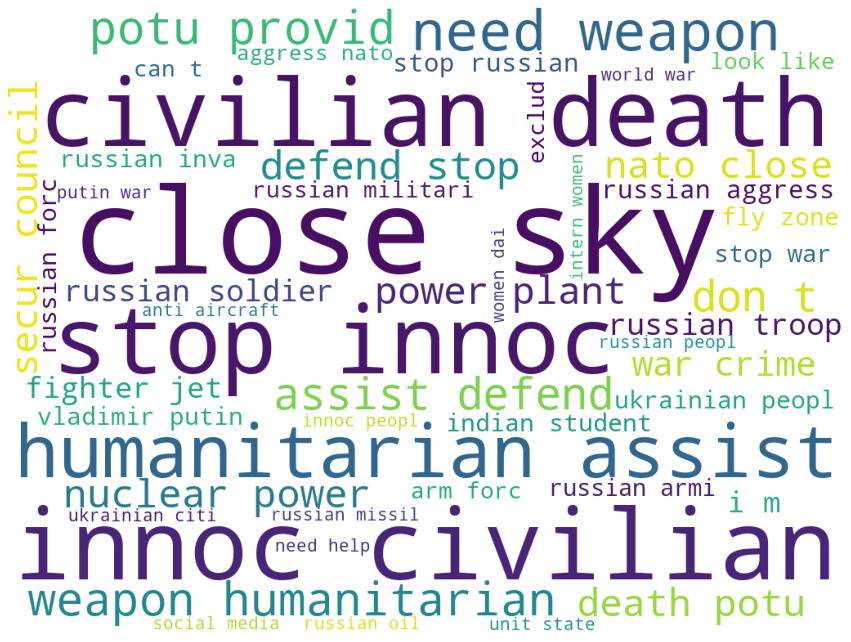

In [45]:
fig, ax = plt.subplots(figsize=(15,15))
mask = np.array(Image.open("twitter.png"))
hashtags_wc = WordCloud(width=1024, height=768, max_words=50,
                collocation_threshold = 4,
                stopwords=['ukrain', 'russia'],
                background_color='white').generate(" ".join(data_no_dup.cleaned_text))
ax.axis("off")
ax.imshow(hashtags_wc)

# Clustering

In [184]:
from sklearn.cluster import KMeans

In [194]:
sse = []
K = range(1, 21)
for num_clusters in K :
    start_time = time.time()
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(sample1)
    sse.append(kmeans.inertia_)
    print(num_clusters, "Took", time.time() - start_time, "s to run.")

1 Took 2.6739039421081543 s to run.
2 Took 5.977431297302246 s to run.
3 Took 8.434545278549194 s to run.
4 Took 11.255988597869873 s to run.
5 Took 13.43511962890625 s to run.
6 Took 13.941349267959595 s to run.
7 Took 14.47143292427063 s to run.
8 Took 16.261935234069824 s to run.
9 Took 19.922345638275146 s to run.
10 Took 20.517654418945312 s to run.
11 Took 23.008954763412476 s to run.
12 Took 24.6674165725708 s to run.
13 Took 24.710785627365112 s to run.
14 Took 24.907548666000366 s to run.
15 Took 25.974156618118286 s to run.
16 Took 28.334646940231323 s to run.
17 Took 30.43257737159729 s to run.
18 Took 32.568279504776 s to run.
19 Took 34.606587648391724 s to run.
20 Took 33.82516932487488 s to run.


In [197]:
K = range(21, 31)
for num_clusters in K :
    start_time = time.time()
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(sample1)
    sse.append(kmeans.inertia_)
    print(num_clusters, "Took", time.time() - start_time, "s to run.")

21 Took 39.36674642562866 s to run.
22 Took 38.191622734069824 s to run.
23 Took 42.692121744155884 s to run.
24 Took 42.89378762245178 s to run.
25 Took 42.030189037323 s to run.
26 Took 45.240967988967896 s to run.
27 Took 45.119271755218506 s to run.
28 Took 55.41738986968994 s to run.
29 Took 55.48868489265442 s to run.
30 Took 52.095471143722534 s to run.


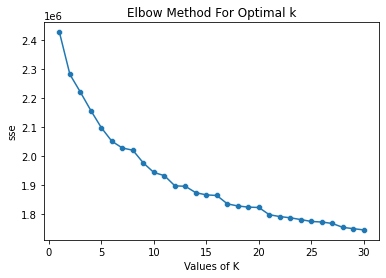

In [199]:
sns.scatterplot(np.arange(1,31), sse)
sns.lineplot(np.arange(1,31), sse)
plt.xlabel('Values of K') 
plt.ylabel('sse') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [200]:
kmeans = KMeans(n_clusters=7, random_state=4225)

In [201]:
kmeans.fit(sample1)

KMeans(n_clusters=7, random_state=4225)

In [204]:
sample1['cluster'] = pd.Series(kmeans.labels_, index=sample1.index)

In [272]:
clust_1 = data_no_dup.filter(items = sample1[sample1['cluster'] == 4].index, axis=0).cleaned_text
clust_1.shape

(17927,)

In [236]:
from collections import Counter

In [276]:
temp = pd.read_csv('training_data.csv')

In [283]:
temp[temp['support']=='ukraine'].text[0]

'@Xenta777 I STAND WITH #UKRAINE AND UKRAINIAN PRESIDENT @ZelenskyyUa \n\n🌻🌻🌻🌻🌻🌻🌻🌻🌻\n\n#StandWithUkraine \n#PuckFutin #Kyiv https://t.co/WAQgSmRO9g'

In [273]:
counter = Counter(" ".join(clust_1).split())

In [274]:
np.array([x[0] for x in counter.most_common(50)][30:])

array(['close', 'countries', 'know', 'news', 'video', 'sanctions',
       'nuclear', 'sky', 'city', 'council', 'said', 'soldiers', 'stand',
       'says', 'going', 'fight', 'kharkiv', 'media', 'army', 'want'],
      dtype='<U9')

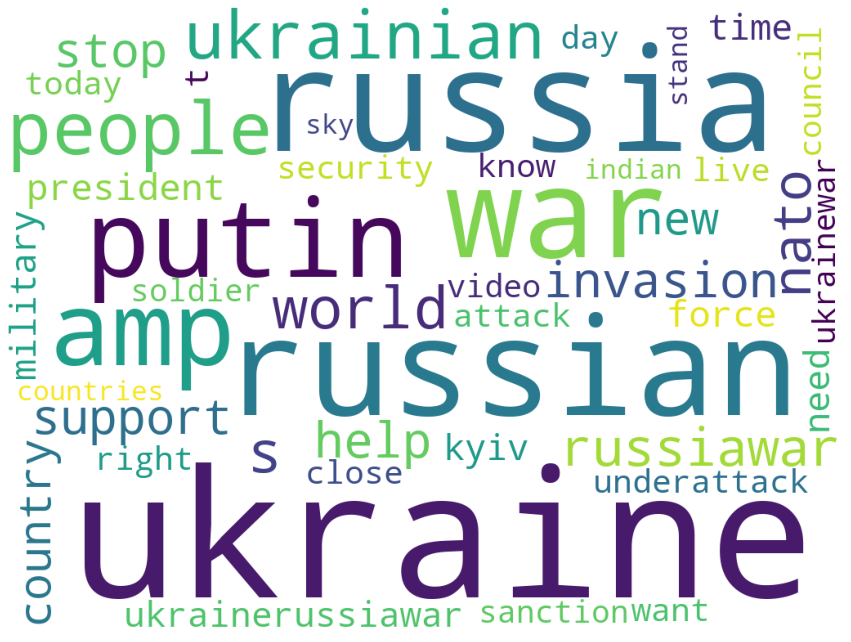

In [228]:
fig, ax = plt.subplots(figsize=(15,15))
hashtags_wc = WordCloud(width=1024, height=768,
                collocations=False, max_words=45,
                background_color='white').generate(" ".join(clust_1))
ax.axis("off")
ax.imshow(hashtags_wc)

In [ ]:
# pyLDAvis.enable_notebook()
# pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds="tsne")

## Number of Tweets Over Time (Hourly)

In [103]:
tweet_per_hr = data.groupby(data.tweetcreatedts.dt.floor("1H")).count()

Text(0, 0.5, 'Number of Tweets')

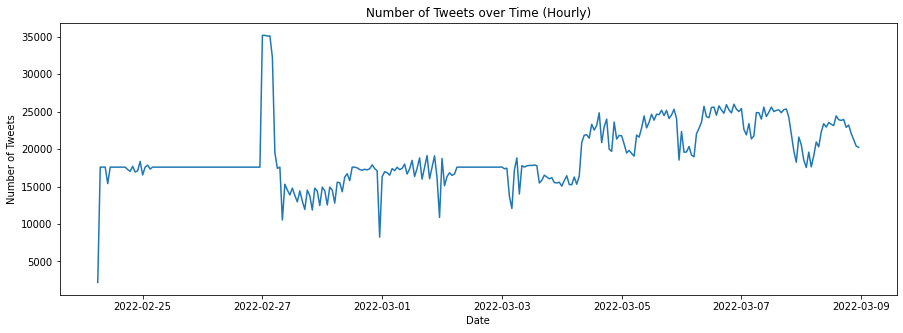

In [111]:
plt.figure(figsize=(15, 5))
sns.lineplot(tweet_per_hr.index, tweet_per_hr.tweetcreatedts)
plt.title("Number of Tweets over Time (Hourly)")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")

In [71]:
en_tweet_per_hr = data_en.groupby(data_en.tweetcreatedts.dt.floor("1H")).count()

In [73]:
import numpy as np

In [119]:
xticks = [i * 24 for i in range(10)]

In [122]:
from datetime import datetime
xticks_label = en_tweet_per_hr.index[xticks].strftime('%d/%m/%Y')

In [128]:
xticks_label = xticks_label.to_list()

In [129]:
xticks_label.append('09/03/2022')
xticks.append(241)

Text(0, 0.5, 'Number of Tweets')

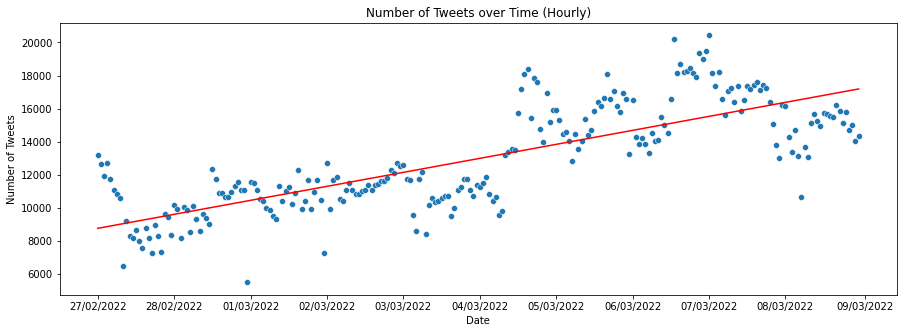

In [130]:
plt.figure(figsize=(15, 5))
sp = sns.scatterplot(np.arange(240), en_tweet_per_hr.tweetcreatedts)
m, b = np.polyfit(np.arange(240), en_tweet_per_hr.tweetcreatedts, 1)
sns.lineplot(np.arange(240), m * np.arange(240) + b, color = 'red')
sp.set_xticks(xticks, labels=xticks_label)
plt.title("Number of Tweets over Time (Hourly)")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")

In [135]:
start_time = time.time()
selected_df = data_en[(data_en["tweetcreatedts"] >= "2022-02-27 00:00") & (data_en["tweetcreatedts"] <= "2022-02-27 05:00")]
vectorizer = CountVectorizer(analyzer="word", min_df=3, max_features=5000,)
data_matrix = vectorizer.fit_transform(selected_df.cleaned_text)
print("Took", time.time() - start_time, "s to run.")

Took 1.1290512084960938 s to run.


In [137]:
start_time = time.time()
lda_model = LatentDirichletAllocation(n_components=10, learning_method="online", random_state=2022, n_jobs = -1)
lda_output = lda_model.fit_transform(data_matrix)
print("Took", time.time() - start_time, "s to run.")

Took 226.25539326667786 s to run.


In [138]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds="tsne")

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  14.491381
2       0.648955  71.707100       2        1  13.519832
3      71.019684   9.971006       3        1  11.514268
8       3.785981  33.185135       4        1  11.263070
1     -42.666500  -9.222070       5        1  10.713950
6      -3.621689 -43.526516       6        1   9.557846
9      -3.632402  -4.171708       7        1   9.290291
7     -36.584400  35.804413       8        1   9.057018
4      44.391380  50.615383       9        1   6.277131
5      40.235809 -31.591665      10        1   4.315213, topic_info=            Term          Freq         Total Category  logprob  loglift
3753     russian  31673.000000  31673.000000  Default  30.0000  30.0000
4136       state   6251.000000   6251.000000  Default  29.0000  29.0000
3744      russia  29671.000000  29671.000000  Default  28.0000  28.0000
721     channels   5132.000000   5132.000000  Default  27.0000  27.0000
1890  government   5723.000000   5723.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
3062    oprussia   3592.348859   5878.835314  Topic10  -2.9440   2.6505
4958         you    428.166215    681.745397  Topic10  -5.0711   2.6779
3753     russian   2119.015054  31673.887917  Topic10  -3.4719   0.4385
1921       group    344.438814    744.163541  Topic10  -5.2887   2.3727
563     breaking    299.531358   2984.829595  Topic10  -5.4284   0.8439

[479 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
29        2  0.999226    according
48        3  0.999517    activists
52        2  0.999335     actually
59        3  0.999766      address
81        6  0.858812       advice
...     ...       ...          ...
4974      7  0.123107     zelensky
4975      1  0.999225    zelenskyy
4976      3  0.999823  zelenskyyua
4987      3  0.999782       россия
4990      3  0.999762      україна

[545 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 9, 2, 7, 10, 8, 5, 6])

## Subjectivity and Polarity

In [284]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
   return TextBlob(text).sentiment.polarity

In [285]:
start_time = time.time()
data_no_dup["subjectivity"] = data_no_dup["cleaned_text"].apply(getSubjectivity)
data_no_dup["polarity"] = data_no_dup["cleaned_text"].apply(getPolarity)
print("Took", time.time() - start_time, "s to run.")

Took 178.53188586235046 s to run.


In [179]:
data_en = data_en.drop(columns=["Unnamed: 0", "userid", "tweetid", "extractedts"])

In [180]:
data_en[data_en["polarity"] == 1].head()

username  \
38         3015nyac   
415   abhielashhere   
752     AmadiKester   
915        vinwin53   
2325     Hannah_SE6   

                                                                                                                   acctdesc  \
38                                                                                                                      NaN   
415                                                                                                                     NaN   
752   This account is dedicated to helping followers, team members and users of Royal Q to earn daily using the Royal Q bot   
915                               The best thing about being me🤔\n I’m a limited edition😷 and there are no other copies!🙉🙈🙊   
2325                                                                                                   Wearer of many hats.   

                      location  following  followers  totaltweets  \
38                  Queens, NY       5000        662       280422   
415         Maharashtra, India        862        161         2049   
752                        NaN        174        176          135   
915   Sawantwadi,Mumbai, India         59        161        90214   
2325                    London        589        391         1443   

                   usercreatedts      tweetcreatedts  retweetcount  \
38    2011-12-14 19:09:42.000000 2022-02-24 06:48:07            16   
415   2015-06-14 12:48:52.000000 2022-02-24 06:48:39             0   
752   2020-05-14 12:32:17.000000 2022-02-24 06:49:13             0   
915   2010-10-07 11:17:18.000000 2022-02-24 06:49:27            14   
2325  2012-05-30 21:20:04.000000 2022-02-24 07:06:05            26   

                                                                                                                                                                                                                                 text  \
38    These are our best and brightest reporters on the ground telling us what is going on as the morning arrives in #Russia and #Ukraine. Follow @clarissaward @fpleitgenCNN @mchancecnn @jimsciutto @npwcnn https://t.co/k8fxHxSm0f   
415                                               @narendramodi &amp; @AmitShah as #Ukrain &amp; #Russia is in war, it's best time to take what ours (#Kashmir &amp; #Sindh) from #Pakistan plus #UP and #2024election will be yours.   
752                                           With the news coming in from #UkraineRussiaConflict #Putin the market is dipping...This is the best time to allow the Royal Q bot trade for you\n#cryptotrading https://t.co/pk1ITDRMKT   
915                                                                              China, Pakistan, Iran Nepal, Sri Lanka are friends of #Russia! While India’s friend is Afghanistan in the region. Modi Ji is having superb choice.👏😁   
2325                                                                             The bells toll, on time, down through time at St Michael's magnificent cathedral in the midst of this moment of danger and disbelief. #Kyiv #Ukraine   

                                                                                                                                                                                                                                                                                                           hashtags  \
38                                                                                                                                                                                                                                                                      [{'text': 'Russia', 'indices': [130, 137]}]   
415   [{'text': 'Ukrain', 'indices': [33, 40]}, {'text': 'Russia', 'indices': [47, 54]}, {'text': 'Kashmir', 'indices': [100, 108]}, {'text': 'Sindh', 'indices': [115, 121]}, {'text': 'Pakistan', 'indices': [128, 137]}, {'text': 'UP', 'indices': [143, 

In [181]:
data_en[data_en["polarity"] == -1].head()

username  \
923     OneMoreTime82   
1048    AlphaInvestin   
1411     Sus_serenity   
1843          IamMsFF   
1959  Radio_Ethiopia2   

                                                                                                                                                             acctdesc  \
923                                                                                    Appearing, on occasion. \n\n"With a song in my heart and a ding in my racket."   
1048  Following us requires $0\n💰 Daily Tips & Updates \n🕵🏻‍♂️ Invest now, you are already late!\n💵 Stock market, Mutual Funds\n📊 Dm 'Alpha' to get FREE consultation   
1411                                                18| i love Genshin Impact but i couldn't play it🙂 for reason i have no laptop, and my phone is only 64GB storage!   
1843                                   Stand with Hongkong,\n😊\nnever surrender, never forgive !\n香港真係好靚\n願你一路走花路，不知人間疾苦\n失去的，日後會讓他們凱旋歸來。 \nPls Follow👉\n@Noblock9me1   
1959                                                                                                                                               案ずるなかれ　行くべきは決まっておる   

                 location  following  followers  totaltweets  \
923   Yorkshire, England.        940        363        26945   
1048        Mumbai, India         40         99          134   
1411                  NaN         80          6          162   
1843                World       1070       2719        50590   
1959      TOKYO JUNK TOWN        395       1211       194270   

                   usercreatedts      tweetcreatedts  retweetcount  \
923   2018-05-19 13:38:06.000000 2022-02-24 06:49:28             6   
1048  2022-01-04 05:16:04.000000 2022-02-24 06:49:39             0   
1411  2021-09-19 08:57:47.000000 2022-02-24 07:01:43             3   
1843  2014-01-19 15:45:09.000000 2022-02-24 07:02:21           212   
1959  2011-01-17 01:42:56.000000 2022-02-24 07:02:31           212   

                                                                                                                                                                                                                                                                                                                     text  \
923   Shocking &amp; distressing to follow events happening in #Ukraine 🇺🇦 from here in Tokyo.\n\nUnprovoked attacks by #Putin will be met with a united response. In my meetings with 🇯🇵 ministers today we are discussing 🇬🇧 &amp; G7 partners standing together against outrageous aggression. https://t.co/iquoliKKOz   
1048                                                                                                                                             2020 and 2021 competing to be the worst years.\n\n2022:\n\n#WorldWarIII #WorldWar3 #RussiaInvadesUkraine #UkraineWar #RussiaUkraine #WorldWarIII https://t.co/juPySY5ZRp   
1411                                                                                                                                                                      #RussiaDeclaresWar \nShocking Visuals from Ukraine's Kyiv.\nWorld War-3...?\n\n#RussiaUkraineConflict #Putin #WorldWar3 https://t.co/AMCjISly3P   
1843                                                   “President Putin: In the name of humanity bring your troops back to #Russia. In the name of humanity do not allow to start in Europe what could be the worst war since the beginning of the century”, @antonioguterres’ message to Russia. https://t.co/SYpojtnEa7   
1959                                                   “President Putin: In the name of humanity bring your troops back to #Russia. In the name of humanity do not allow to start in Europe what could be the worst war since the beginning of the century”, @antonioguterres’ message to Russia. https://t.co/SYpojtnEa7   

                                                                                                                                          

In [182]:
data_en[data_en["polarity"] == 0].head()

username  \
0         toonspt_   
1  IndiaTodayFLASH   
2       Areopagiet   
3      Sicarius130   
4        qwerty_cr   

                                                                                                                                                      acctdesc  \
0                                                                                                                      พยรลก 😉\nจะเปิดแอคเมื่อขายของเท่านั้น!!   
1                                                                                               No dragging feet on news. Crisp & short news shots served here   
2                                                   Dᴀᴅ ღ Pʜɪ & Qᴜɪ /Pᴀʀᴛɴᴇʀ | Aᴛʜᴇɪsᴛ | ADD /ASS \n\n#StandWithAfghanistan\n#StandWithBelarus\n#StandWithIran   
3  Christie // 刀剣乱舞 (izmt+mtiz for life) + 2.5D (刀ミュ&有澤樟太郎&田村心) + twst (Leona) + mhyk (Cain) + FGO // Eng+中文+日本語少し // Ao3: Akame_no_Youkai // read carrd byf 👇   
4                                                                                              🇯🇵 @Bgs_Emex 🏆8452 ladder #51, #137, #187 GT #27, #79, #92, #98   

    location  following  followers  totaltweets               usercreatedts  \
0        NaN        462          7        20549  2012-11-21 13:01:19.000000   
1        NaN        117    1152610       589066  2013-01-09 12:46:38.000000   
2    EU v2.0       5008        267         9894  2018-09-13 07:29:55.000000   
3  Hong Kong        459        272        57829  2015-10-08 04:49:27.000000   
4   ホワイトルシアン        595       1243         2620  2018-12-18 17:56:13.000000   

       tweetcreatedts  retweetcount  \
0 2022-02-24 06:48:02          1897   
1 2022-02-24 06:48:02            18   
2 2022-02-24 06:48:03          1552   
3 2022-02-24 06:48:03          1032   
4 2022-02-24 06:48:03          1897   

                                                                                                                                                                                   text  \
0                                                                                           Footage of the airport bombing in Ivano-Frankivsk. #Ukraine #Russia https://t.co/MLVuNyPItI   
1  Ukraine MP Sophia Fedyna tells about the ground situation in Kyiv in an exclusive conversation with @Akshita_N .\n\n#ITVideo #Russia #Ukraine #Kyiv #Kharkiv https://t.co/TtPt1UZqhz   
2                                                                                   A cruise missile fired by the Russian army fell on Kiev #Ukraine\n#Russia \nhttps://t.co/x0Cty5sDjX   
3                                                                                                       SPREAD AND SHARE, YOU CAN HELP UKRAINE #Ukraine #Russia https://t.co/rp2IFCKMi3   
4                                                                                           Footage of the airport bombing in Ivano-Frankivsk. #Ukraine #Russia https://t.co/MLVuNyPItI   

                                                                              hashtags  \
0  [{'text': 'Ukraine', 'indices': [68, 76]}, {'text': 'Russia', 'indices': [77, 84]}]   
1                                         [{'text': 'ITVideo', 'indices': [130, 138]}]   
2  [{'text': 'Ukraine', 'indices': [72, 80]}, {'text': 'Russia', 'indices': [81, 88]}]   
3  [{'text': 'Ukraine', 'indices': [55, 63]}, {'text': 'Russia', 'indices': [64, 71]}]   
4  [{'text': 'Ukraine', 'indices': [68, 76]}, {'text': 'Russia', 'indices': [77, 84]}]   

  language coordinates  favorite_count  \
0       en         NaN               0   
1       en         NaN               0   
2       en         NaN               0   
3       en         NaN               0   
4       en         NaN               0   

                                                                                                   cleaned_text  \
0                                                                       footage airport bombing ivano frankivsk   
1  ukraine sophia fedyna tells ground situation

In [183]:
data_en[data_en["subjectivity"] == 1].head()

username  \
284     Ronnykhupse   
405   SanjivMenezes   
426     Lord_Frosty   
463  Priyanshu_2811   
574      RiyanWarga   

                                                                                                                                                   acctdesc  \
284                                                                                                                    Work hard and believe in yourself🤟🤟🤟   
405                                                                                   Truth Seeker, Pragmatist, Egalitarian, Environmentalist, Minimalist 🙏   
426  Follower of Christ, USAF Vet, & Doctoral Student. I am looking for Lords who have similar interest in: Tech, Gaming, Science, Business, Politics, etc.   
463                                                                                                                         Tech Enthusiasts 🙌 | Love Anime   
574                                                                                                                                              Penyesatan   

                         location  following  followers  totaltweets  \
284                           NaN        179          8          157   
405                           NaN        236        119         4875   
426          From the 80's & 90's         77        201        32412   
463  Village Hidden in the Leaves        251        138         3327   
574                           NaN        252         71          604   

                  usercreatedts      tweetcreatedts  retweetcount  \
284  2022-01-04 09:03:29.000000 2022-02-24 06:48:28           328   
405  2009-01-02 10:55:39.000000 2022-02-24 06:48:38             0   
426  2009-06-26 05:10:11.000000 2022-02-24 06:48:40          2189   
463  2019-05-21 08:18:10.000000 2022-02-24 06:48:43           530   
574  2020-02-01 04:09:35.000000 2022-02-24 06:48:55          1065   

                                                                                                                                                                                                                                                                                                         text  \
284                                                                                             People in Ukraine gather to pray in the freezing cold and at the brink of war.\n\nVery heart breaking 💔\n\n#Ukraina\n#UkraineRussie\n#RussiaUkraine \n#UkraineConflict \n#WorldWarIII https://t.co/yGKzKZLkyW   
405                                              @DatFishe @AliceTheLeftist In a war you are always on one side or the other. It is not possible to sit on the fence with semantics!\n#Belarus has to assume the same responsibility and suffer the same consequences as #russia whether they like it or not!   
426  #Russia is now working on:\n\n-establishing air superiority via targeted surgical strikes\n-a pincer movement to trap Ukrainian forces in the east &amp; cut them off from #Kyiv \n-finally attempt to decapitate Ukrainian govt by targeting govt buildings,leaders &amp; command &amp; control systems   
463                                                                                                                                                                         Very apt representation 🤣 #PutinsWar #UkraineRussiaCrisis #Ukrain #Biden #worldwar3 #RussiaUkraine #PUTIN https://t.co/ZhO0Qic8GR   
574                                                                                                                                                                                                           Now hearing jets over Belgorod. Possibly flying towards the Kharkiv area. #CNN #Russia #Ukraine   

                                                                                                                                                                                                                                              

In [184]:
data_en[data_en["subjectivity"] == 0].head()

username  \
0         toonspt_   
1  IndiaTodayFLASH   
2       Areopagiet   
3      Sicarius130   
4        qwerty_cr   

                                                                                                                                                      acctdesc  \
0                                                                                                                      พยรลก 😉\nจะเปิดแอคเมื่อขายของเท่านั้น!!   
1                                                                                               No dragging feet on news. Crisp & short news shots served here   
2                                                   Dᴀᴅ ღ Pʜɪ & Qᴜɪ /Pᴀʀᴛɴᴇʀ | Aᴛʜᴇɪsᴛ | ADD /ASS \n\n#StandWithAfghanistan\n#StandWithBelarus\n#StandWithIran   
3  Christie // 刀剣乱舞 (izmt+mtiz for life) + 2.5D (刀ミュ&有澤樟太郎&田村心) + twst (Leona) + mhyk (Cain) + FGO // Eng+中文+日本語少し // Ao3: Akame_no_Youkai // read carrd byf 👇   
4                                                                                              🇯🇵 @Bgs_Emex 🏆8452 ladder #51, #137, #187 GT #27, #79, #92, #98   

    location  following  followers  totaltweets               usercreatedts  \
0        NaN        462          7        20549  2012-11-21 13:01:19.000000   
1        NaN        117    1152610       589066  2013-01-09 12:46:38.000000   
2    EU v2.0       5008        267         9894  2018-09-13 07:29:55.000000   
3  Hong Kong        459        272        57829  2015-10-08 04:49:27.000000   
4   ホワイトルシアン        595       1243         2620  2018-12-18 17:56:13.000000   

       tweetcreatedts  retweetcount  \
0 2022-02-24 06:48:02          1897   
1 2022-02-24 06:48:02            18   
2 2022-02-24 06:48:03          1552   
3 2022-02-24 06:48:03          1032   
4 2022-02-24 06:48:03          1897   

                                                                                                                                                                                   text  \
0                                                                                           Footage of the airport bombing in Ivano-Frankivsk. #Ukraine #Russia https://t.co/MLVuNyPItI   
1  Ukraine MP Sophia Fedyna tells about the ground situation in Kyiv in an exclusive conversation with @Akshita_N .\n\n#ITVideo #Russia #Ukraine #Kyiv #Kharkiv https://t.co/TtPt1UZqhz   
2                                                                                   A cruise missile fired by the Russian army fell on Kiev #Ukraine\n#Russia \nhttps://t.co/x0Cty5sDjX   
3                                                                                                       SPREAD AND SHARE, YOU CAN HELP UKRAINE #Ukraine #Russia https://t.co/rp2IFCKMi3   
4                                                                                           Footage of the airport bombing in Ivano-Frankivsk. #Ukraine #Russia https://t.co/MLVuNyPItI   

                                                                              hashtags  \
0  [{'text': 'Ukraine', 'indices': [68, 76]}, {'text': 'Russia', 'indices': [77, 84]}]   
1                                         [{'text': 'ITVideo', 'indices': [130, 138]}]   
2  [{'text': 'Ukraine', 'indices': [72, 80]}, {'text': 'Russia', 'indices': [81, 88]}]   
3  [{'text': 'Ukraine', 'indices': [55, 63]}, {'text': 'Russia', 'indices': [64, 71]}]   
4  [{'text': 'Ukraine', 'indices': [68, 76]}, {'text': 'Russia', 'indices': [77, 84]}]   

  language coordinates  favorite_count  \
0       en         NaN               0   
1       en         NaN               0   
2       en         NaN               0   
3       en         NaN               0   
4       en         NaN               0   

                                                                                                   cleaned_text  \
0                                                                       footage airport bombing ivano frankivsk   
1  ukraine sophia fedyna tells ground situation

Text(0.5, 1.0, 'Distribution of Polarity')

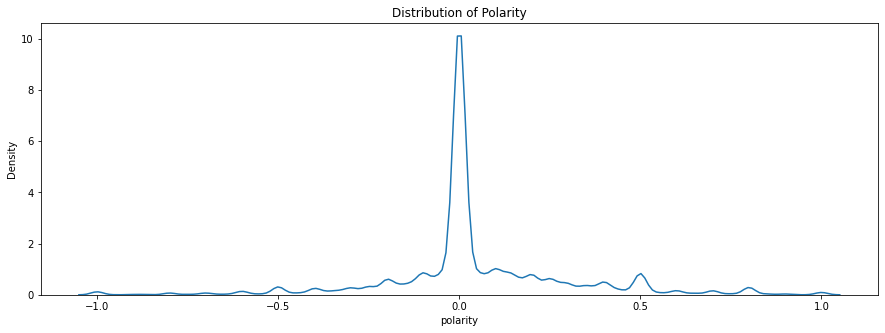

In [286]:
plt.figure(figsize=(15, 5))
sns.kdeplot(x="polarity", data=data_no_dup)
plt.title("Distribution of Polarity")

Text(0.5, 1.0, 'Distribution of Subjectivity')

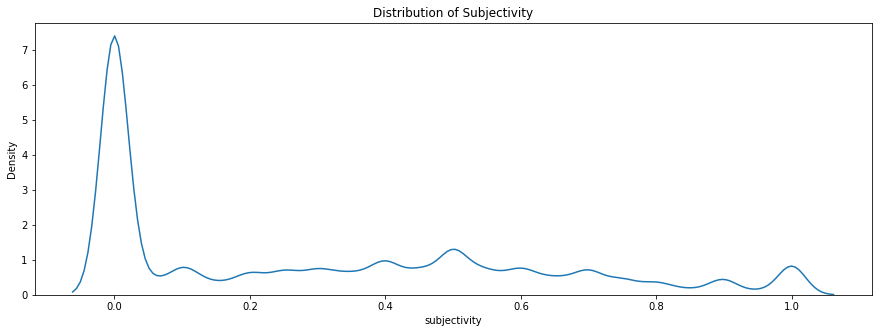

In [287]:
plt.figure(figsize=(15, 5))
sns.kdeplot(x="subjectivity", data=data_no_dup)
plt.title("Distribution of Subjectivity")

## Retweets

In [191]:
data_en.drop_duplicates("text").shape

(1051143, 17)

In [192]:
data_en.shape

(3837590, 17)

In [301]:
data_en[data_en["text"] == data_en.text[10000]]

username  \
2407         FOXXXXFIRE5   
2579     _PEACHEZNCREAM_   
2829         HeidiKooten   
3229          shormeegod   
3231         AngelTaylor   
...                  ...   
784237   AtlantaMdtwnGuy   
796115   brightangelhike   
1630549         HAttyias   
1703367      MeskeTeresa   
1769615   keith_mckeever   

                                                                                                                                  acctdesc  \
2407     Biden/Harris 🇺🇲🇺🇲🇺🇲 Democrat, Wa. State Caregiver. Vaccinated with booster and still wears mask. Kind, caring and honest! No DM'S   
2579                                                                                                 they/she | 24 | aqua stellium | gamma   
2829                                                           Bleeding ❤️ liberal. Proud daughter of Hildegard and Lawrence. 🤗 Joe's girl   
3229     Faith Man...Thinking Man....Action Man......God conscious ...Made in Africa....No 1 Milanista...Child of God..Addicted to The ...   
3231                                                                                                                                   NaN   
...                                                                                                                                    ...   
784237                                     Progressive Christian, Jesus Follower, World Traveler, Educator, Marketing Executive/Strategist   
796115   Science education, world traveler, ultra liberal, DOG lover. Portuguese, French,  and some Spanish spoken. #Resist  UNION SUPP...   
1630549                                                                                                                                NaN   
1703367                                                                                                                                NaN   
1769615                                               Realtor with Fathom Realty / Real Estate Educator / Podcast Host / Air Force Veteran   

                               location  following  followers  totaltweets  \
2407                                NaN      14592      13575       124798   
2579                         Louisiana        1310       1808       148814   
2829                            Chicago       1124       1717        31793   
3229                              Lagos        407        434        21629   
3231                             Oregon        292         43          448   
...                                 ...        ...        ...          ...   
784237   Global Citizen-may be anywhere       1993        701         7608   
796115                    New York, USA       1827        449        12850   
1630549                             NaN         86         10         1003   
1703367                     Phoenix, AZ        833         99        10069   
1769615                       Pekin, IL        143         16           47   

              usercreatedts      tweetcreatedts  retweetcount  \
2407    2011-04-27 03:26:05 2022-02-24 07:06:09          6750   
2579    2013-09-02 17:21:17 2022-02-24 07:06:17          6750   
2829    2020-09-23 01:39:32 2022-02-24 07:06:32          6750   
3229    2009-09-14 06:11:58 2022-02-24 07:06:54          6726   
3231    2008-08-24 21:29:34 2022-02-24 07:06:54          6726   
...                     ...                 ...           ...   
784237  2010-01-19 06:52:32 2022-02-27 04:58:00         11443   
796115  2013-03-20 11:41:49 2022-02-27 05:59:00         11444   
1630549 2018-02-15 17:07:26 2022-03-02 16:38:14         11437   
1703367 2015-06-28 02:21:20 2022-03-02 22:42:48         11438   
1769615 2012-05-17 00:08:41 2022-03-03 04:33:13         11439   

                                                                                                                                      text  \
2407     If you’re an American, and your not tracking on #Ukraine, now is the time to start. This is just not anot

## Key Topics Over Time

In [255]:
data_per_day = data_en.groupby(data_en.tweetcreatedts.dt.floor("D")).apply(lambda x : " ".join(x["cleaned_text"]))

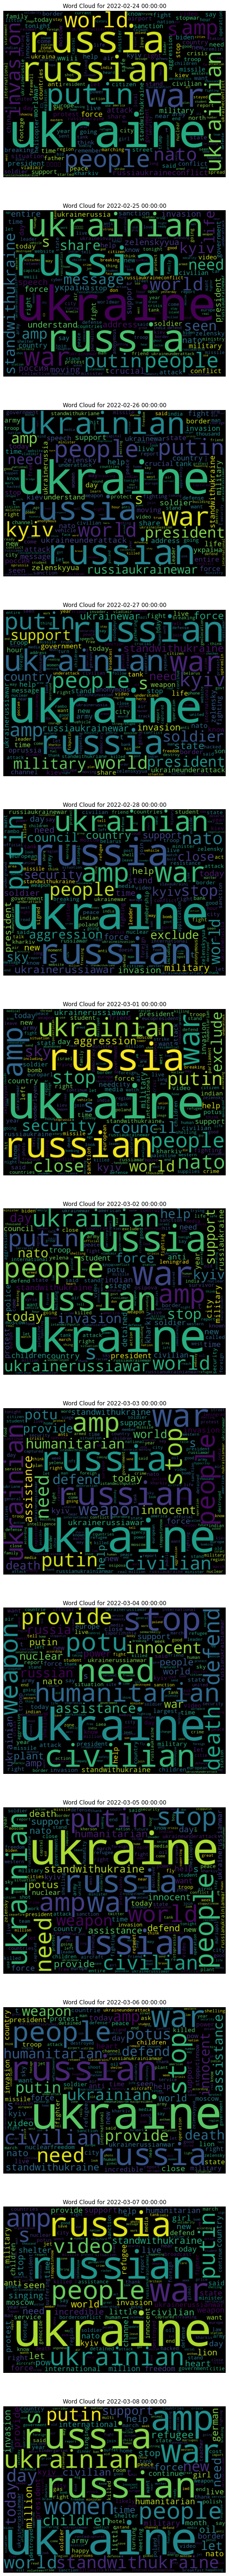

In [262]:
plt.figure(figsize=(100,100))
i = 1
for index, value in data_per_day.items():
    plt.subplot(13, 1, i).set_title(f"Word Cloud for {index}")
    plt.plot()
    plt.imshow(WordCloud(width=1024, height=768, collocations=False).generate(value))
    plt.axis("off")
    i += 1

## Account Life

In [395]:
data_no_dup["accountlife"] = data_no_dup["tweetcreatedts"] - data_no_dup["usercreatedts"]

In [397]:
x = data_no_dup[data_no_dup["accountlife"] < timedelta(minutes=30)]

In [403]:
x.columns

Index(['userid', 'username', 'acctdesc', 'location', 'following', 'followers',
       'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts',
       'retweetcount', 'text', 'hashtags', 'language', 'coordinates',
       'favorite_count', 'extractedts', 'cleaned_text', 'subjectivity',
       'polarity', 'accountlife'],
      dtype='object')

In [404]:
x.loc[x['totaltweets'] > 100, ['username', 'totaltweets', 'usercreatedts', 'tweetcreatedts']].drop_duplicates('username')

username  totaltweets       usercreatedts      tweetcreatedts
344811     BelaaKaterina          105 2022-02-28 12:11:02 2022-02-28 12:29:04
347188   SlavaUk30210419          120 2022-02-28 12:16:19 2022-02-28 12:43:10
347293     DEnis14975689          138 2022-02-28 12:27:44 2022-02-28 12:43:12
348057    soul_of_embers          110 2022-02-28 12:19:03 2022-02-28 12:43:56
348747       MelVasylyna          101 2022-02-28 12:16:24 2022-02-28 12:44:15
380923      LaAc20146007          149 2022-02-28 15:23:13 2022-02-28 15:42:37
386847      UkrainkaTana          101 2022-02-28 15:45:59 2022-02-28 16:13:04
394772   DianaJo85462169          110 2022-02-28 16:32:07 2022-02-28 16:45:17
604933          NPUAFree          126 2022-03-01 12:28:17 2022-03-01 12:47:36
673329    Vernon48181165          137 2022-03-01 18:44:24 2022-03-01 19:03:43
767605    FreeUkraine100          122 2022-03-02 03:24:32 2022-03-02 03:50:28
1234329       Basillisk3          165 2022-03-03 21:59:31 2022-03-03 22:08:43
1348698     YurchukIrina          118 2022-03-04 08:04:32 2022-03-04 08:30:49
1379122        OfPoeople          102 2022-03-04 10:21:59 2022-03-04 10:46:48
1489686     ArturKotofej          201 2022-03-04 17:05:05 2022-03-04 17:27:55
1755149  CarlosW12189077          215 2022-03-05 10:54:14 2022-03-05 11:12:40
1758839       MikeDavisY          111 2022-03-05 11:06:22 2022-03-05 11:27:09
1770533        AdrysFdyl          246 2022-03-05 12:15:00 2022-03-05 12:15:19
1771773   AlqlshanyRslan          112 2022-03-05 12:19:12 2022-03-05 12:19:34

## Autocorrect

In [313]:
spell = Speller(lang = "en")

# More EDA (not used)

In [306]:
def listandtokenize(data):
    yourlist = data.tolist()
    string = ' '.join(yourlist)
    return string.split()

In [308]:
lines = listandtokenize(data_no_dup.cleaned_text)

In [312]:
import collections
def count_ngrams(lines, min_length=2, max_length=4):
    lengths = range(min_length, max_length+1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen = max_length)
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current)>= length:
                ngrams[length][current[:length]] +=1
    for word in lines:
        queue.append(word)
        if len(queue) >= max_length:
            add_queue()
    while len(queue) > min_length:
        queue.popleft()
        add_queue()
    return ngrams

In [313]:
def print_most_freq_ng(ngrams, num=15):
    for n in sorted(ngrams):
        print('----{} most frequent {}-grams ----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')